In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from astropy    import units
from matplotlib import pyplot as plt

from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

from common import hallmark as hm
from common import mockservation as mk
from common import dalt
from common import viz

In [2]:
pf = hm.ParaFrame('cache/SPO2023/gt_60e9/{NGC}_a{aspin:g}_i{inc:g}_{freq}.h5')

for k in set(pf.keys()) - {'path'}:
    globals()[k] = np.unique(pf[k])
    print(k, globals()[k][:16])

inc [ 50. 160.]
NGC ['NGC3998' 'NGC4261' 'NGC4594']
aspin [-0.94 -0.5   0.    0.5   0.94]
freq ['230.e9' '345.e9' '86.e9']


In [ ]:
freq = ['86.e9', '230.e9', '345.e9']

In [26]:
def load(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
    return dalt.Image(data, meta=meta)
        
# viz should be v[s, :, :] in accessing gt file
# but v[:, :, s] in accessing other file e.g. avg

def plot_img(ax, pf):
    if len(pf) != 1:
        return 
    
    img = load(pf.path.iloc[0])

    viz.show(img, s=0, ax=ax, cmap='afmhot', labels=False)
    ax.xaxis.set_ticks(np.linspace(-25,25,5))
    ax.yaxis.set_ticks(np.linspace(-25,25,5))
    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

def plot_vis(ax, pf):
    if len(pf) != 1:
        return 
    
    img = load(pf.path.iloc[0])
    vis = mk.mockserve(img, N=512)
    viz.show(vis, s=0, ax=ax, f=lambda v: np.log(abs(v)), labels=False)
    #ax.xaxis.set_ticks(np.linspace(-25,25,5))
    #ax.yaxis.set_ticks(np.linspace(-25,25,5))
    ax.tick_params(color='w')
    for spine in ax.spines.values():
        spine.set_edgecolor('w')

def plot_curve(ax ,pf):

    img = load(pf.path.iloc[0])
    vis = mk.mockserve(img, N=512)
    U, V = vis.uvd

    u = np.linspace( 0,   U/2, num=vis.shape[-1])
    v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t = vis.meta.time.value

    amp = RegularGridInterpolator((t, v, u[::-1]), abs     (vis[...,::-1]))
    phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))

    bmin = 6e9
    bmax = 10e9

    uvd = np.linspace(0, bmax, round(bmax/1e7)+1)

    for i in range(-90,90,45):
        phi = np.pi * i / 180

        u = uvd * np.cos(phi)
        v = uvd * np.sin(phi)

        mask = u <= 0
        
        p = np.array([np.repeat(t[0], np.sum( mask)),  v[ mask],  u[ mask]]).T
        m = np.array([np.repeat(t[0], np.sum(~mask)), -v[~mask], -u[~mask]]).T
        
        s = np.zeros(len(uvd))
        s[ mask] = amp(p)
        s[~mask] = amp(m)
            
        label = f'i={i}'
        if i == -90:
            label += ' (horizontal)'
        elif i == 0:
            label += ' (vertial)'
        ax.semilogy(uvd/1e9, s/s[0], label=label)#, ':' if i < 0 else '-')


(1000, 30, 30)


<Axes: xlabel='$x$ [$\\mathrm{\\mu as}$]', ylabel='$y$ [$\\mathrm{\\mu as}$]'>

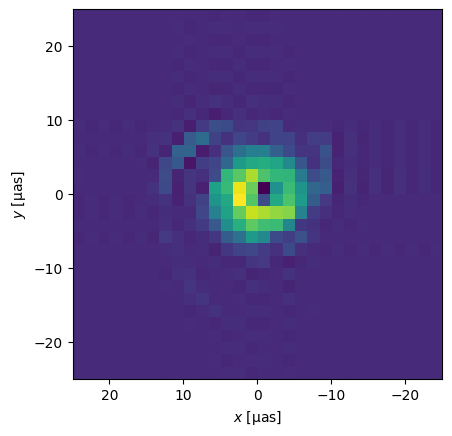

In [4]:
mov = load(pf.path.iloc[0])
print(mov.shape)
viz.show(mov, s=0)

In [ ]:
# Plotting image

for obj in NGC:
    for i in inc:
        fig = viz.grid(pf(NGC=obj)(inc=i), plot_img, aspin=aspin, freq=freq,
                        figsize=(10,10),
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$x$ [$\mu$as]', ylabel=r'$y$ [$\mu$as]', 
                        fout=f'output/plot/gt/img_{obj}_{i}')
        plt.show()
        plt.close(fig)

<Axes: xlabel='u [G$\\lambda$]', ylabel='v [G$\\lambda$]'>

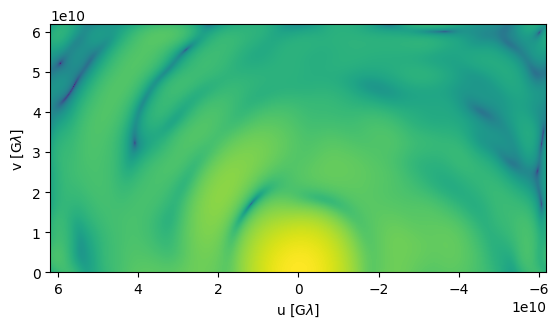

In [11]:
# Plotting Characteristic Wavelength
vis = mk.mockserve(mov, N=512)
viz.show(vis, s=0, f=lambda v: np.log(abs(v)), labels=[r'$u [G\lambda]$', r'$v [G\lambda]$'])

In [ ]:
for obj in NGC:
    for i in inc:
        fig = viz.grid(pf(NGC=obj)(inc=i), plot_vis, aspin=aspin, freq=freq,
                        figsize=(10,5),
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$u [G\lambda]$', ylabel=r'$v [G\lambda]$', 
                        fout=f'output/plot/gt/vis_{obj}_{i}')
        plt.show()
        plt.close(fig)

In [ ]:
for obj in 'NGC3998':
    for i in 50:
        fig = viz.grid(pf(NGC=obj)(inc=i), plot_curve, aspin=[+0.94], freq=['230.e9'],
                        figsize=(10,10),
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$x$ [$\mu$as]', ylabel=r'$y$ [$\mu$as]', 
                        fout=f'output/plot/gt/img_{obj}_{i}')
        plt.show()
        plt.close(fig)

In [ ]:
U, V = vis.uvd

u = np.linspace( 0,   U/2, num=vis.shape[-1])
v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
t = vis.meta.time.value

amp = RegularGridInterpolator((t, v, u[::-1]), abs     (vis[...,::-1]))
phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))

<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:36: SyntaxWarning: invalid escape sequence '\l'
/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_2155/305774114.py:36: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$u$-$v$ distance [G$\lambda$]')


6001


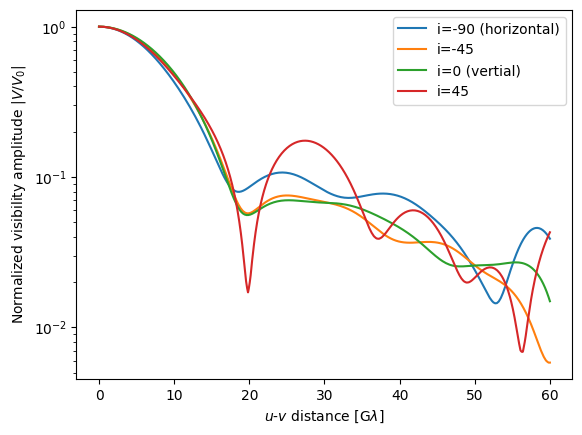

In [111]:
bmin = 6e9
bmax = 60e9

uvd = np.linspace(0, bmax, round(bmax/1e7)+1)
print(len(uvd))

for i in range(-90,90,45):
    phi = np.pi * i / 180

    u = uvd * np.cos(phi)
    v = uvd * np.sin(phi)

    mask = u <= 0
    
    p = np.array([np.repeat(t[0], np.sum( mask)),  v[ mask],  u[ mask]]).T
    m = np.array([np.repeat(t[0], np.sum(~mask)), -v[~mask], -u[~mask]]).T
    
    s = np.zeros(len(uvd))
    s[ mask] = amp(p)
    s[~mask] = amp(m)
        
    label = f'i={i}'
    if i == -90:
        label += ' (horizontal)'
    elif i == 0:
        label += ' (vertial)'
    plt.semilogy(uvd/1e9, s/s[0], label=label)#, ':' if i < 0 else '-')

    #lm = argrelextrema(s, np.less)[0]
    #plt.scatter(uvd[lm], s[lm]/s[0])
    
    #ms = np.median(s[(bmin < uvd) & (uvd < bmax)]) / s[0]
    #plt.plot([bmin, bmax], [ms, ms], ':' if i < 0 else '-', alpha=1/3)

plt.legend()
plt.xlabel('$u$-$v$ distance [G$\lambda$]')
plt.ylabel('Normalized visibility amplitude $|V/V_0|$')
plt.show()

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/var/folders/f5/93qk9czs7835g6z9_k6k6wvc0000gn/T/ipykernel_9733/4132926125.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v
/var/folders/f5

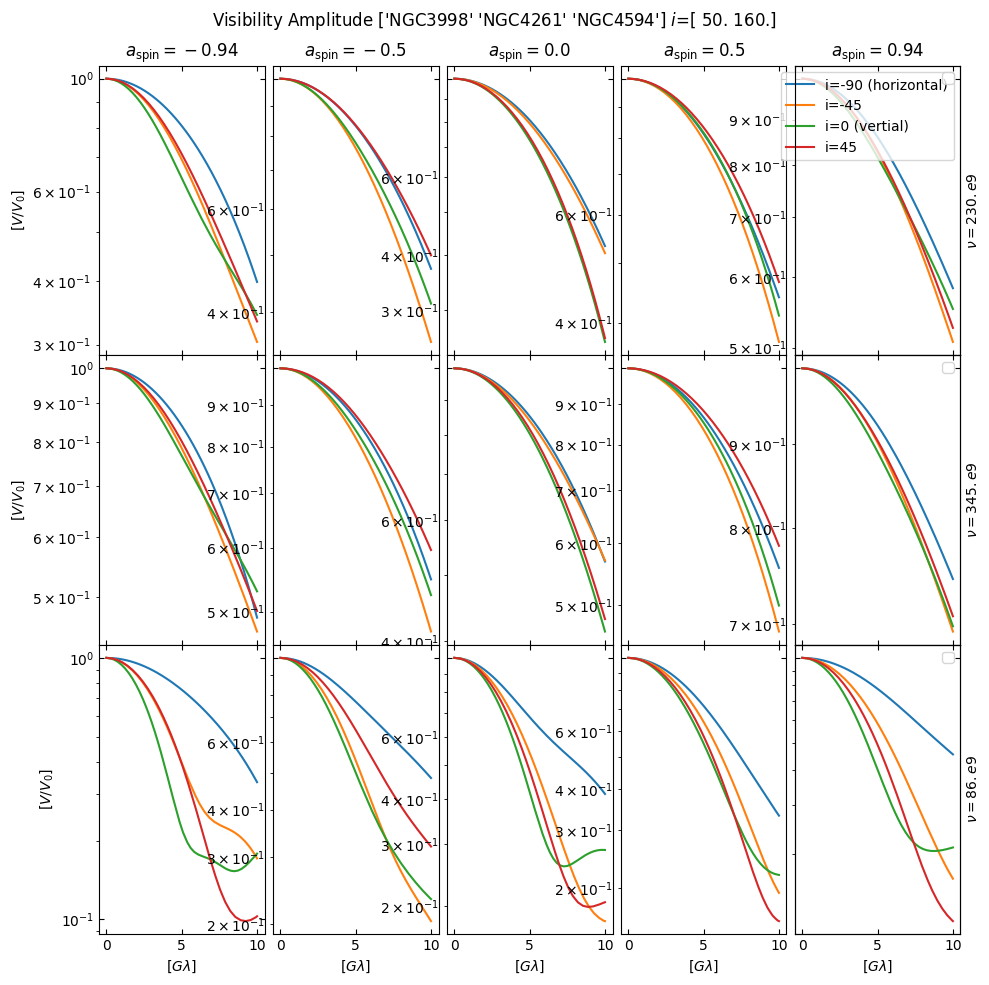

/Users/caritsang/Desktop/Project/2024SURE/proj/postprocessing/2017_sgra_paper5/common/hallmark.py:28: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask |= self[k] == v


KeyboardInterrupt: 

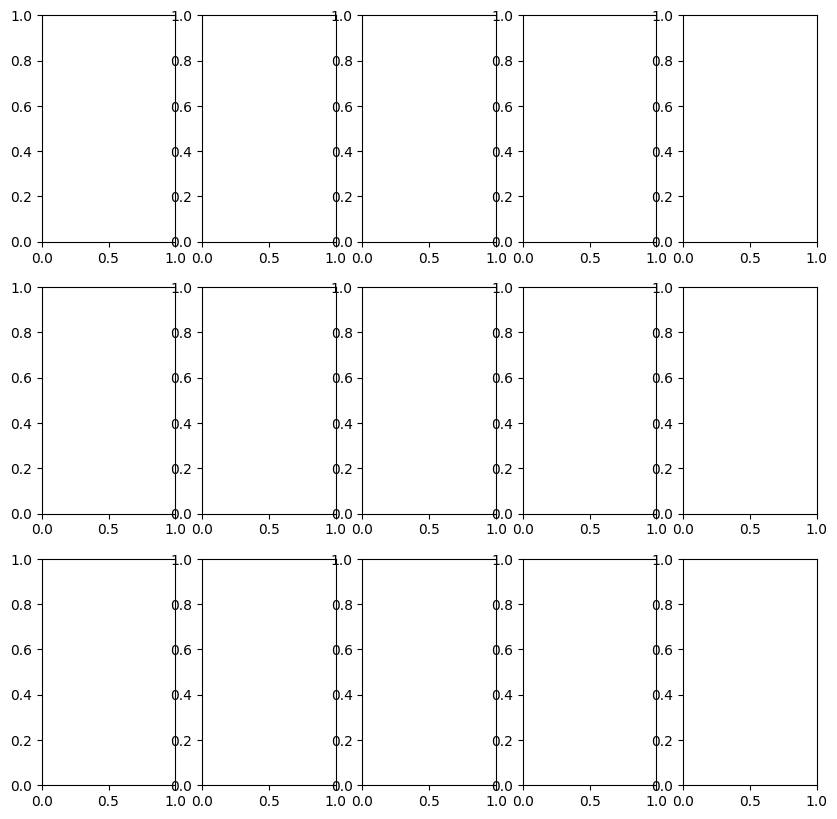

In [33]:
for obj in NGC:
    for i in inc:
        fig = viz.grid(pf(NGC=obj)(inc=i), plot_curve, aspin=aspin, freq=freq,
                        figsize=(10,10), title=f"Visibility Amplitude {obj} $i$={i}",
                        xtitle=r'$a_\mathrm{{spin}}={}$',  ytitle=r'$\nu={}$',
                        xlabel=r'$[G\lambda]$', ylabel=r'[$V/V_0$]', legend=True,
                        fout=f'output/plot/gt/10e9curve_{obj}_{i}')
        plt.show()
        plt.close(fig)